# KBO OPS 예측

### 1. 목적

- 2019년 타자들의 상반기 OPS를 예측하는 모델 개발

### 데이터 구조

```
${data}
├─ Pre_Season_Batter.csv
├─ Regular_Season_Batter.csv
├─ Regular_Season_Batter_Day_by_Day_b4.csv
└─ submission.csv
```

- Pre_Season_Batter : KBO에서 활약한 타자들의 역대 정규시즌 성적을 포함하여 몸무게, 키 ,생년월일 등의 기본정보
- Regular_Season_Batter_Day_by_Day.csv: KBO에서 활약한 타자들의 일자 별 정규시즌 성적
- Pre_Season_Batter.csv : KBO에서 활약한 타자들의 역대 시범경기(정규시즌 직전에 여는 연습경기) 성적
- submission.csv : 참가자들이 예측해야 할 타자의 이름과 아이디 목록

     - 데이터 컬럼 정리
       - 'batter_id' : 타자 아이디
       - 'batter_name' : 타자 이름
       - 'year' : 해당 년도
       - 'team' : 팀
       - 'avg' : 평균 타율
       - 'G' : 출장 경기
       - 'AB' : 타수
       - 'R' : 득점
       - 'H' : 안타
       - '2B': 2루타
       - '3B' : 3루타
       - 'HR' : 홈런
       - 'TB' : 총루타
       - 'RBI': 타점
       - 'SB' : 도루 성공
       - 'CS' : 도루 실패
       - 'BB' : 볼넷
       - 'HBP': 사사구
       - 'SO' : 삼진
       - 'GDP': 병살
       - 'SLG': 장타율
       - 'OBP': 출루율
       - 'E' : 에러
       - 'height/weight': 키/몸무게
       - 'year_born': 나이
       - 'position': 포지션
       - 'career' : 커리어
       - 'starting_salary' : 연봉
       - 'OPS' : OPS

### 프로젝트 구조

```
${PROJECT}
├── results/
├── data/
│   ├─ Pre_Season_Batter.csv
│   ├─ Regular_Season_Batter.csv
│   ├─ Regular_Season_Batter_Day_by_Day_b4.csv
│   └─ submission.csv
├── EDA.ipynb
├── preprocessing.ipynb
└── Model.ipynb
```


## Library import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [50]:
from preprocessing import team_change, weigth, weight_to_category, age_to_category

In [3]:
def get_font_family():
    import platform 
    system_name = platform.system()

    if system_name == "Darwin" : # 맥
        font_family = "AppleGothic"
    elif system_name == "Windows": # 윈도우
        font_family = "Malgun Gothic"
    else: # 리눅스 및 코랩
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv
        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        font_family = "NanumBarunGothic"
    return font_family

plt.style.use("seaborn") # 전체 그래프를 seaborn 스타일로 고정
plt.rc("font", family=get_font_family())
matplotlib.rcParams['axes.unicode_minus'] = False # 그래프에 마이너스 허용

%config InlineBackend.figure_format = 'retina' # 그래프를 더 선명하게 사용


plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 120
plt.rcParams.update({'font.size': 20})

C:\Users\DH\AppData\Local\Temp\ipykernel_37420\1105408730.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn") # 전체 그래프를 seaborn 스타일로 고정


## Load Data

In [4]:
regular = pd.read_csv("./data/Regular_Season_Batter.csv")

regular

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686
3,1,강경학,2015,한화,0.257,120,311,50,80,7,...,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673
4,1,강경학,2016,한화,0.158,46,101,16,16,3,...,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,344,황진수,2014,롯데,0.000,5,5,0,0,0,...,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000
2450,344,황진수,2015,롯데,0.000,2,2,0,0,0,...,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000
2451,344,황진수,2016,롯데,0.000,11,10,2,0,0,...,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000
2452,344,황진수,2017,롯데,0.291,60,117,18,34,6,...,2,0.402,0.359,4,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.761


In [5]:
pre = pd.read_csv("./data/Pre_Season_Batter.csv")

pre

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,...,1,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959
1,1,강경학,2011,한화,0.000,4,2,2,0,0,...,0,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500
2,1,강경학,2014,한화,-,4,0,2,0,0,...,0,NaN,NaN,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,NaN
3,1,강경학,2015,한화,0.130,10,23,3,3,0,...,0,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416
4,1,강경학,2016,한화,0.188,14,32,4,6,1,...,0,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,342,황재균,2014,롯데,0.407,10,27,3,11,2,...,0,0.593,0.448,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,1.041
1389,342,황재균,2015,롯데,0.333,11,30,8,10,3,...,0,0.433,0.389,0,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.822
1390,342,황재균,2016,롯데,0.310,16,42,8,13,3,...,0,0.429,0.370,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.799
1391,342,황재균,2018,KT,0.250,6,16,3,4,1,...,0,0.500,0.333,3,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.833


In [6]:
day = pd.read_csv("./data/Regular_Season_Batter_Day_by_Day_b4.csv")

day

,batter_id,batter_name,date,opposing_team,avg1,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,HBP,SO,GDP,avg2,year
0,0,가르시아,3.24,NC,0.333,3,1,1,0,0,0,0,0,0,1,0,1,0,0.333,2018
1,0,가르시아,3.25,NC,0.000,4,0,0,0,0,0,0,0,0,0,0,1,0,0.143,2018
2,0,가르시아,3.27,넥센,0.200,5,0,1,0,0,0,0,0,0,0,0,0,0,0.167,2018
3,0,가르시아,3.28,넥센,0.200,5,1,1,0,0,0,1,0,0,0,0,0,0,0.176,2018
4,0,가르시아,3.29,넥센,0.250,4,0,1,0,0,0,3,0,0,0,0,0,1,0.190,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112268,344,황진수,6.23,LG,-,0,0,0,0,0,0,0,0,0,1,0,0,0,0.158,2018
112269,344,황진수,6.26,넥센,0.000,1,0,0,0,0,0,0,0,0,0,0,1,0,0.150,2018
112270,344,황진수,6.27,넥센,0.500,2,1,1,1,0,0,0,0,0,0,0,1,0,0.182,2018
112271,344,황진수,6.28,넥센,-,0,0,0,0,0,0,0,0,0,0,0,0,0,0.182,2018


## Preprocessing

In [7]:
regular["team"].value_counts()

한화      302
롯데      298
LG      294
두산      282
삼성      280
SK      254
KIA     254
넥센      172
NC      131
KT       85
현대       60
우리       13
히어로즈     13
해태       12
OB        3
쌍방울       1
Name: team, dtype: int64

- 위의 팀들을 살펴봤을 때 데이터의 처리가 팀 별로 구분이 되어있다. 
- 하지만, 여러 팀에서 경기를 진행한 선수의 경우 팀별로 다른 양상을 보이기에 통합이 필요함

- 쌍방울레이더스의 경우 1999년 해체 후 2000년도 부터 SK가 이어 받아 진행하였고,
- OB의 경우 두산베어스로, 해태의 경우 기아타이거즈, 우리 및 서울 히어로즈의 경우 전부 넥센 히어로즈의 전신이기 때문에
- 팀의 데이터를 획일화 시켜주기 위하여 팀의 전신도 동일 팀이라 취급하여 전처리를 한다. 

In [8]:
regular[regular["team"] == "쌍방울"]

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
1674,234,이진영,1999,쌍방울,0.258,65,190,14,49,5,...,3,0.0,0.0,2,185cm/90kg,1980년 06월 15일,외야수(좌투좌타),군산초-군산남중-군산상고-쌍방울-SK-LG,10000만원,0.0


In [59]:
regular[regular["batter_name"] == "이진영"].head(3)

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,OBP,E,height/weight,year_born,OPS,외국인,weight,weight_category,age,age_category
1674,234,이진영,1999,SK,0.258,65,190,14,49,5,...,0.000,2,185cm/90kg,1980,0.000,1,90.0,2.0,19,0
1675,234,이진영,2000,SK,0.247,105,292,34,72,16,...,0.000,3,185cm/90kg,1980,0.000,1,90.0,2.0,20,0
1676,234,이진영,2001,SK,0.280,120,321,49,90,16,...,0.351,4,185cm/90kg,1980,0.753,1,90.0,2.0,21,0


In [10]:
regular[regular["team"] == "OB"]

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
19,297,진갑용,1997,OB,0.242,95,281,21,68,7,...,7,0.309609,0.306189,6,NaN,1974년 05월 08일,NaN,하단초-초량중-부산고-고려대-OB-두산-삼성,NaN,0.615797
20,297,진갑용,1998,OB,0.269,88,253,12,68,14,...,10,0.355731,0.307116,7,NaN,1974년 05월 08일,NaN,하단초-초량중-부산고-고려대-OB-두산-삼성,NaN,0.662847
272,32,김동주,1998,OB,0.265,125,457,69,121,21,...,14,0.472648,0.319838,9,NaN,1976년 02월 03일,NaN,중대초-배명중-배명고-고려대-OB-두산,NaN,0.792486


In [60]:
regular[regular["batter_name"] == "김동주"].head(3)

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,OBP,E,height/weight,year_born,OPS,외국인,weight,weight_category,age,age_category
272,32,김동주,1998,두산,0.265,125,457,69,121,21,...,0.319838,9,NaN,1976,0.792486,1,NaN,NaN,22,0
273,32,김동주,1999,두산,0.321,114,399,62,128,25,...,0.397778,7,NaN,1976,0.961688,1,NaN,NaN,23,1
274,32,김동주,2000,두산,0.339,127,469,78,159,29,...,0.418386,17,NaN,1976,1.021798,1,NaN,NaN,24,1


In [61]:
regular[regular["batter_name"] == "진갑용"].head(3)

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,OBP,E,height/weight,year_born,OPS,외국인,weight,weight_category,age,age_category
19,297,진갑용,1997,두산,0.242,95,281,21,68,7,...,0.306189,6,NaN,1974,0.615797,1,NaN,NaN,23,1
20,297,진갑용,1998,두산,0.269,88,253,12,68,14,...,0.307116,7,NaN,1974,0.662847,1,NaN,NaN,24,1
21,297,진갑용,1999,삼성,0.212,68,156,13,33,3,...,0.267857,7,NaN,1974,0.575549,1,NaN,NaN,25,1


In [47]:
regular["team"] = regular["team"].apply(team_change)

In [48]:
regular

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,OBP,E,height/weight,year_born,OPS,외국인,weight,weight_category,age,age_category
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,0.383,9,177cm/93kg,1985,0.902,0,93.0,2.0,33,2
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0.000,1,180cm/72kg,1992,0.000,1,72.0,0.0,19,0
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,0.337,6,180cm/72kg,1992,0.686,1,72.0,0.0,22,0
3,1,강경학,2015,한화,0.257,120,311,50,80,7,...,0.348,15,180cm/72kg,1992,0.673,1,72.0,0.0,23,1
4,1,강경학,2016,한화,0.158,46,101,16,16,3,...,0.232,7,180cm/72kg,1992,0.489,1,72.0,0.0,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,344,황진수,2014,롯데,0.000,5,5,0,0,0,...,0.000,0,181cm/82kg,1989,0.000,1,82.0,1.0,25,1
2450,344,황진수,2015,롯데,0.000,2,2,0,0,0,...,0.000,0,181cm/82kg,1989,0.000,1,82.0,1.0,26,1
2451,344,황진수,2016,롯데,0.000,11,10,2,0,0,...,0.000,0,181cm/82kg,1989,0.000,1,82.0,1.0,27,1
2452,344,황진수,2017,롯데,0.291,60,117,18,34,6,...,0.359,4,181cm/82kg,1989,0.761,1,82.0,1.0,28,1


- 외국인 타자인지 아닌지에 따라서 OPS에 영향을 줄 수 있다고 생각하여 외국인 인지 아닌지 여부를 처리
- 0 이면 외국인 1이면 한국인

In [18]:
foreign = pd.DataFrame({"name":["가르시아", "고메즈", "대니돈", "러프", "로맥", "로메로",
                                "로사리오", "로티노", "로하스", "스나이더", "스크럭스", "알드리지",
                                "초이스", "칸투", "테임즈", "피에", "호잉"]})


In [19]:
regular.loc[regular["batter_name"].isin(foreign["name"]), "외국인"] = 0
regular.loc[~regular["batter_name"].isin(foreign["name"]), "외국인"] = 1

In [20]:
regular["외국인"] = regular["외국인"].astype("int")

- OPS의 경우 출루율과 장타율에 영항을 받는다
- 몸무게에 따라 몸무게가 적게 나가는 선수의 경우 출루율이 높다고 판단, 몸무게가 많이 나가는 선수의 경우 장타율이 높다고 판단하여
- 몸무게를 기준으로 범주화

     - 하지만 몸무게 결측치가 800개 가량되기에 상당히 근 결측치라 사용할지 말지 고려해 봐야함

In [22]:
df = regular.copy()

In [23]:
df_weight = df[["height/weight"]].dropna()

In [26]:
df_weight["weight"] = df_weight['height/weight'].apply(weigth)

In [27]:
regular["weight"] = df_weight["weight"]

- 몸무게의 4분위수를 활용하여 1사분위수 부터 3사분위수 까지 구간을 정하여 범주화
- 하지만 결측치가 있어서 사용할 수 있을지 논의 필요

In [30]:
regular["weight_category"] = regular["weight"].apply(weight_to_category)

- 나이에 따른 에이징 커브가 있다고 가정
- 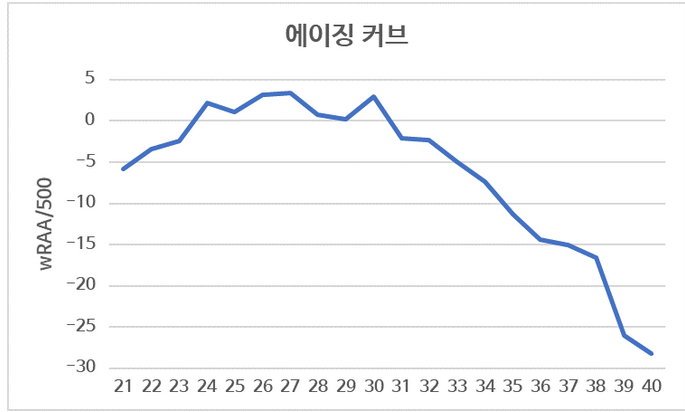

- kbo 선수 에이징 커브에 기준에 따라 나이를 범주화 한다.
- 23세 29세 38세를 기준으로 범주화

In [31]:
regular["year_born"] = regular["year_born"].apply(lambda x: int(str(x)[:4]))

In [32]:
regular["age"] = regular["year"] - regular["year_born"]

In [34]:
regular["age_category"] = regular["age"].apply(age_to_category)

In [43]:
regular.drop(["career", "starting_salary", "position"], axis=1, inplace=True)

In [44]:
regular.to_csv("./data/Regular_Season_Batter_pre.csv", index=None)

In [45]:
pd.read_csv("./data/Regular_Season_Batter_pre.csv")

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,OBP,E,height/weight,year_born,OPS,외국인,weight,weight_category,age,age_category
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,0.383,9,177cm/93kg,1985,0.902,0,93.0,2.0,33,2
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0.000,1,180cm/72kg,1992,0.000,1,72.0,0.0,19,0
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,0.337,6,180cm/72kg,1992,0.686,1,72.0,0.0,22,0
3,1,강경학,2015,한화,0.257,120,311,50,80,7,...,0.348,15,180cm/72kg,1992,0.673,1,72.0,0.0,23,1
4,1,강경학,2016,한화,0.158,46,101,16,16,3,...,0.232,7,180cm/72kg,1992,0.489,1,72.0,0.0,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,344,황진수,2014,롯데,0.000,5,5,0,0,0,...,0.000,0,181cm/82kg,1989,0.000,1,82.0,1.0,25,1
2450,344,황진수,2015,롯데,0.000,2,2,0,0,0,...,0.000,0,181cm/82kg,1989,0.000,1,82.0,1.0,26,1
2451,344,황진수,2016,롯데,0.000,11,10,2,0,0,...,0.000,0,181cm/82kg,1989,0.000,1,82.0,1.0,27,1
2452,344,황진수,2017,롯데,0.291,60,117,18,34,6,...,0.359,4,181cm/82kg,1989,0.761,1,82.0,1.0,28,1


In [52]:
pre.drop(["career", "starting_salary", "position"], axis=1, inplace=True)

In [55]:
pre["team"] = pre["team"].apply(team_change)

In [64]:
pre.loc[regular["batter_name"].isin(foreign["name"]), "외국인"] = 0
pre.loc[~regular["batter_name"].isin(foreign["name"]), "외국인"] = 1

In [69]:
pre["weight"] = pre['height/weight'].apply(weigth)

In [72]:
pre["weight_category"] = pre["weight"].apply(weight_to_category)

In [74]:
pre["year_born"] = pre["year_born"].apply(lambda x: int(str(x)[:4]))

In [76]:
pre["age"] = pre["year"] - pre["year_born"]

In [79]:
pre["age_category"] = pre["age"].apply(age_to_category)

In [80]:
pre

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,OBP,E,height/weight,year_born,OPS,외국인,weight,weight_category,age,age_category
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,...,0.409,1,177cm/93kg,1985,0.959,0.0,93,2,33,2
1,1,강경학,2011,한화,0.000,4,2,2,0,0,...,0.500,0,180cm/72kg,1992,0.500,1.0,72,0,19,0
2,1,강경학,2014,한화,-,4,0,2,0,0,...,NaN,0,180cm/72kg,1992,NaN,1.0,72,0,22,0
3,1,강경학,2015,한화,0.130,10,23,3,3,0,...,0.286,2,180cm/72kg,1992,0.416,1.0,72,0,23,1
4,1,강경학,2016,한화,0.188,14,32,4,6,1,...,0.212,0,180cm/72kg,1992,0.493,1.0,72,0,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,342,황재균,2014,롯데,0.407,10,27,3,11,2,...,0.448,1,183cm/96kg,1987,1.041,1.0,96,3,27,1
1389,342,황재균,2015,롯데,0.333,11,30,8,10,3,...,0.389,0,183cm/96kg,1987,0.822,1.0,96,3,28,1
1390,342,황재균,2016,롯데,0.310,16,42,8,13,3,...,0.370,1,183cm/96kg,1987,0.799,1.0,96,3,29,2
1391,342,황재균,2018,KT,0.250,6,16,3,4,1,...,0.333,3,183cm/96kg,1987,0.833,1.0,96,3,31,2


In [81]:
pre.to_csv("./data/Pre_Season_Batter_pre.csv", index=None)

In [82]:
pd.read_csv("./data/Pre_Season_Batter_pre.csv")

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,OBP,E,height/weight,year_born,OPS,외국인,weight,weight_category,age,age_category
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,...,0.409,1,177cm/93kg,1985,0.959,0.0,93,2,33,2
1,1,강경학,2011,한화,0.000,4,2,2,0,0,...,0.500,0,180cm/72kg,1992,0.500,1.0,72,0,19,0
2,1,강경학,2014,한화,-,4,0,2,0,0,...,NaN,0,180cm/72kg,1992,NaN,1.0,72,0,22,0
3,1,강경학,2015,한화,0.130,10,23,3,3,0,...,0.286,2,180cm/72kg,1992,0.416,1.0,72,0,23,1
4,1,강경학,2016,한화,0.188,14,32,4,6,1,...,0.212,0,180cm/72kg,1992,0.493,1.0,72,0,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,342,황재균,2014,롯데,0.407,10,27,3,11,2,...,0.448,1,183cm/96kg,1987,1.041,1.0,96,3,27,1
1389,342,황재균,2015,롯데,0.333,11,30,8,10,3,...,0.389,0,183cm/96kg,1987,0.822,1.0,96,3,28,1
1390,342,황재균,2016,롯데,0.310,16,42,8,13,3,...,0.370,1,183cm/96kg,1987,0.799,1.0,96,3,29,2
1391,342,황재균,2018,KT,0.250,6,16,3,4,1,...,0.333,3,183cm/96kg,1987,0.833,1.0,96,3,31,2
